# Imports

In [92]:
# Import dependencies

# Flatiron school cohort package
from fsds_100719.imports import *

# nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Preprocessing
import re
import string
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.sparse import vstack
import pandas as pd
import numpy as np
import os

# Modeling
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Wordcloud
from wordcloud import WordCloud, STOPWORDS 

#Pillow
from PIL import Image

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dougl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Functions

In [475]:
def multi_class_SMOTE(X, y, n, random_state, verbose=1):
    """Using imblearn.over_sampling.SMOTE, performs (n-1) iterations of SMOTE to facilitate creating balanced target classes when multiple classes are present.

    Parameters
    ----------
    X : array-like
        Matrix containing the feature data to be sampled
    y : array-like (1-d)
        Corresponding target labels for each sample in X
    n : int
        Number of unique classes/labels in y
    random_state : int
        Value to set as the random_state for SMOTE function reproducibility
    verbose : int (1 or 2)
        If 1, prints label counts only after final SMOTE iteration
        If 2, prints label counts at each SMOTE iteration (including initial)

    Returns
    ----------
    X_resampled : array-like
        Matrix containing the resampled feature data
    y_resampled : array-like (1-d)
        Corresponding target labels for X_resampled
    """

    # Initialize a SMOTE object
    smote = SMOTE(random_state=random_state)

    # Output if verbose = 2
    if verbose == 2:
        print(f'Label counts for Original y:\n{pd.Series(y).value_counts()}')

    # Perform SMOTE n-1 times to achieve balanced target classes
    for i in range(n - 1):
        X, y = smote.fit_sample(X, y)

        # Print value counts after each step if verbose == 2
        if verbose == 2:
            print(
                f'Label counts after SMOTE # {i+1}:\n{pd.Series(y).value_counts()}')

    # Print final value counts if verbose == 1
    if verbose == 1:
        print(
            f'Label counts after SMOTE # {n-1}:\n{pd.Series(y).value_counts()}')

    X_resampled = X
    y_resampled = y

    return X_resampled, y_resampled

def clean_tweet(tweet):
    
    # Remove punctuation
    tweet = tweet.translate(string.punctuation)
    tweet = tweet.lower().split()
    
#     stemmer = SnowballStemmer("english")
#     tweet = [stemmer.stem(word) for word in tweet]
    # Remove stop words
#     tweet = [word for word in tweet if word not in stopwords_list]
    tweet = " ".join(tweet)
#   
    # Regular expressions
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r";", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", "", tweet)
    tweet = re.sub(r":", "", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ", tweet)
    tweet = re.sub(r"\+", "plus", tweet)
    tweet = re.sub(r"\-", "minus", tweet)
    tweet = re.sub(r"\=", "equals", tweet)
    tweet = re.sub(r"'", "", tweet)
    
    return tweet

# Obtain

In [94]:
# Load kaggle airline sentiment dataset and only select sentiment scores with 100% confidence

kaggle_df = pd.read_csv('kaggle_airline_sentiment.csv')
kaggle_df = kaggle_df.loc[kaggle_df['airline_sentiment_confidence'] == 1]

len(kaggle_df)

10445

In [95]:
# Load raw American Airlines tweets obtained from twitter API

twitter_df = pd.read_csv('twitter_30_days_all_airlines.csv')

twitter_df.head()

id                        datetime  \
0  1234991579502243843  Tue Mar 03 23:58:32 +0000 2020   
1  1234991364468690944  Tue Mar 03 23:57:40 +0000 2020   
2  1234991343853654017  Tue Mar 03 23:57:36 +0000 2020   
3  1234991315319848961  Tue Mar 03 23:57:29 +0000 2020   
4  1234991155688792066  Tue Mar 03 23:56:51 +0000 2020   

                                                text  retweets  
0  Just announced: @united says for flights booke...         1  
1  Does @Alitalia really stands on its position o...         2  
2  Hey @Delta I need to track down a past flight ...         0  
3  Hey @Delta now we’re stuck because you cancele...         0  
4  OMG! I’m flying @americanair. All I can think ...         0

In [96]:
twitter_df.to_csv('twitter_df.csv', index=True)

# Scrub

In [97]:
# Identify stop words
stopwords_list = stopwords.words('english')
punc_list = list(string.punctuation)
stopwords_list += punc_list
str_ell_list = ["''", '""', '...', '``']
stopwords_list += str_ell_list

## Clean tweet text

In [99]:
# Clean tweets in kaggle dataset
kaggle_df['clean_text'] = kaggle_df['text'].map(lambda x: clean_tweet(x))    

kaggle_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                           1.0   
3  570301031407624196          negative                           1.0   
4  570300817074462722          negative                           1.0   
5  570300767074181121          negative                           1.0   
9  570295459631263746          positive                           1.0   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
9            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   
5                    NaN    jnardino                 NaN              0   
9                    NaN  YupitsTate                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   
5  @VirginAmerica seriously would pay $30 a fligh...         NaN   
9  @VirginAmerica it was amazing, and arrived an ...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   
5  2015-02-24 11:14:33 -0800            NaN  Pacific Time (US & Canada)   
9  2015-02-24 10:53:27 -0800    Los Angeles  Eastern Time (US & Canada)   

                                          clean_text  
0                 virginamerica what  dhepburn said   
3   virginamerica its really aggressive to blast ...  
4   virginamerica and its a really big bad thing ...  
5   virginamerica seriously would pay  30 a fligh...  
9   virginamerica it was amazing  and arrived an ...

In [100]:
# Clean tweets in twitter dataset

twitter_df['clean_text'] = None
for i in twitter_df.index:
    twitter_df['clean_text'][i] = clean_tweet(twitter_df['text'][i])
    
twitter_df.head()

id                        datetime  \
0  1234991579502243843  Tue Mar 03 23:58:32 +0000 2020   
1  1234991364468690944  Tue Mar 03 23:57:40 +0000 2020   
2  1234991343853654017  Tue Mar 03 23:57:36 +0000 2020   
3  1234991315319848961  Tue Mar 03 23:57:29 +0000 2020   
4  1234991155688792066  Tue Mar 03 23:56:51 +0000 2020   

                                                text  retweets  \
0  Just announced: @united says for flights booke...         1   
1  Does @Alitalia really stands on its position o...         2   
2  Hey @Delta I need to track down a past flight ...         0   
3  Hey @Delta now we’re stuck because you cancele...         0   
4  OMG! I’m flying @americanair. All I can think ...         0   

                                          clean_text  
0  just announced  united says for flights booked...  
1  does  alitalia really stands on its position o...  
2  hey  delta i need to track down a past flight ...  
3  hey  delta now we re stuck because you cancele...  
4  omg i m flying  americanair  all i can think a...

In [101]:
# Test of kaggle dataset cleaned text

for i in kaggle_df['clean_text']:
    print(i)

 virginamerica what  dhepburn said 
 virginamerica its really aggressive to blast obnoxious  entertainment  in your guests faces  amp  they have little recourse
 virginamerica and its a really big bad thing about it
 virginamerica seriously would pay  30 a flight for seats that didnt have this playing plusits really the only bad thing about flying va
 virginamerica it was amazing  and arrived an hour early  youre too good to me 
 virginamerica i  lt 3 pretty graphics  so much better than minimal iconography  d
 virginamerica this is such a great deal already thinking about my 2nd trip to  australia  amp  i havent even gone on my 1st trip yet  p
 virginamerica thanks
 virginamerica so excited for my first cross country flight lax to mco ive heard nothing but great things about virgin america   29daystogo
 virginamerica i flew from nyc to sfo last week and couldnt fully sit in my seat due to two large gentleman on either side of me  help
i    flying  virginamerica     
 virginamerica you

 southwestair 40 minutes still havent talked to one person  shocking phone is gonna died before i talk to anyone 
 southwestair flight 4315  n231wn  taxis at  flytpa prior to flight to  fly nashville 
 southwestair at fort launder dale and the gate agent cant switch flights to an earlier flight but we can on our phone   ridiculous
 southwestair so why is every single flight out of  portcolumbuscmh cancelled flightled for only your airline 
 southwestair cancelled flightled my flight wont refund me and told me 2 call customer service n been holding for 30 minutes still waitin  badservice
 southwestair im going to need you to answer your phones  being on hold for an hour isnt okay 
 southwestair almost an hour on hold for swa is inexcusable  hiremorepeople
 southwestair is my favorite airline i cant wait to book my flight to new orleans for my trip in april    
 southwestair thanks for not telling us our flight was cancelled flightled  not helping us in anyway and ruining my birthday   w

 usairways  americanair i was supposed to get from fresno to pittsburgh by 10pm  instead im now not getting in until 4pm    tomorrow
 usairways  americanair im stuck in the airport in fresno trying to beat the storm to pittsburgh  and you guys have offered nothing  horrid
 usairways hello i have a question for you and your phone lines have jammed
 usairways  americanair u are the worst airline ever figure out the merger  dontmakemegooutside
 usairways    americanair are incompetent 
 usairways now the next plane had a broken seat my row another hour delay  mad
 usairways how can i make a purchase  you take the money but i dont have a reservation   explain
 usairways  americanair are u paying incedentals   noworstairline
 usairways  americanair thought u merged but  usairways sucks  worstever 
 usairways yes i did thank you they did a great job turning the flight in jan 
 usairways 2 hours on hold and issue still not resolved  hope to make my flight in 12 hours  for every minute of talk

In [102]:
# Test of twitter dataset cleaned text

for i in twitter_df['clean_text']:
    print(i)

just announced  united says for flights booked between 3 3 and 3 31 no change fees for the next 12 months 
does  alitalia really stands on its position of not reimbursing tickets to italy  while  delta and united do 
hey  delta i need to track down a past flight receipt  i emailed ticketreceipt delta com last week and still haven t heard from them 
hey  delta now we re stuck because you canceled a flight which was already paid for and didn t even rebook your customers   
omg i m flying  americanair  all i can think about is beverly bass  the first female american captain in history   wecomefromaway nyaweh for teaching us her story  i ll be think about her all the way to  to minus and listen to your soundtrack  it s habit now  
also  my  southwestair flight from austin to st  louis was absolutely wonderful the lady who sat next to me was the other lady having to listen to drunk amys wailing  we chatted the whole way here and shes lovely  fastfriendswithvita
shout out to wendy at gate 46

better hope your  flyfrontier flight doesnt get cancelled  sure theyll pay for your ticket on another airline but you have to pay for any bags  and you better get back to the original airport too because they wont reimburse you if you need a rental car 
check out this  job  hr generalist  employee processing at  southwestairlines   dallas   
headed to nyc via  delta for commercialtheaterinstitute 3minusday producers workshop  heard tell of something called  5 am  minusminus  madre de dios     the legends are true big props to my early riser hub refuheo who  
right   delta putting corporate profit above doing the right thing to help curb the spread of covid19 
get up to 50  on all the domestic and international flight booking of delta airlines call minus plus1minus8665661244plusplus unitedairlines  travel  airtickets  usa  etihad  entertainment  traveling  traveltuesday  traveltips  discountoffer plus etihad  united  delta 
first time commuting on  united and the crew on 4439 jaxminusor

4 flights this weekend  4 on time departures and early arrivals thank you  americanair and your great crews  flymyrtlebeach  flytpa  intlairportclt 
 spiritairlines you motherfuckers totally fucked me i paid 330  for a roundtrip ticket to come see my mom die then you told me you would credit my flight home cause the circumstances that was last wednesday its now sunday and flights are more expensive 71  voucher huh      wow 
flying  united and about 50 carry on bags had to be checked  customers already about to board the plane had to turn around and tag the bags  talk about annoying  how could you oversell overhead space on a flight thats not even sold out 
dont fly  spiritairlines minus they wont send you a confirmation email on your flight in a timely manner minus they wont send you a link to change your password in a timely manner minus but they will dm you on  twitter to let you know someone will investigate  spiritairlinessucks 
the  buffalosabres gliding into  pitairport on a  del

be better  orbitz  tapportugalair  americanair  chase with your refund policies in regards to coronavirus  that s all  just be better  
i wish  united would just go away because like like the worst airline ever they come nowhere close to  delta minus nowhere i waited for 62 days just to be told they didn t receive 1 of the 5 photos i sent regarding my claim  mind you  all photos where in the same eminusmail initially
coach t and the rest of the team are ready for  takeoff to the spring games  thanks to  jetblue  
 firsttweet  delta help i am supposed to visit family in portland but one of their teachers has covidminus19  can i please change my flight 
some just showed their age while on the phone at the  delta  skyclub they told someone on the phone they were in the crown room  skymileslife  travel  delta
every time i buy a flight months ahead of time from  flyfrontier they always fuck up my trip by cutting it short with their schedule changes  don t put out a time frame that is conven

mind blogging to me how i speak with not 1 but 2  americanair reps over the phone who confirmed i would obtain a refund due to an immediate death in the family  i follow the process w  required docs  only to receive a  sorry for your loss but can t refund your ticket  email 
i m never booking with spirit again plus spiritairlines smd
heres an updated list of credit cards ive churned and what rules affect churning these cards plusplusread more     churning  creditcard  creditcards  barclays 
everyone should avoid traveling with  americanairlines because they clearly value profits over safety   americanair
we cant say enough bad things about  unitedairlines customer service 
fellow traveler who helped me getting up the stairs at reagan airport with my luagage on tuesday  many many many thanks  americanair the transfer to gates 36minus45 is atrocious no elevator signs  had to climb 3 flights of stairs with language on a bad knee  americanairlines
thanks once again to  southwestair for hoo

strangers on a plane throw impromptu baby shower for couple flying home with newly adopted infant   this is why i fly southwest 90  of the time  the employees are awesome
 lorelei ready  jetblue for  jax 
 wtfee demand  americanair   united  delta put  safetyoverprofits  seat children with parents at no additional cost  sign  cradvocacy petition  
from dfw to sea i always fly alaska air   snow  mountains  iamalaska  iflyalaska  dfw  sea  alaskaair 
find out why we rated  delta five starsplusplus
 never  fly with  flyfrontier theyll lose your bag then try and give you  700 for your grandpas ashes and tell you that your valuables have deprecated  flying with anyone but them   southwestair  delta here i come   blacktwitter
apply now to work for  southwestairlines as solutions  architect    network security   dallas   job  
 never  fly with  flyfrontier theyll lose your bag then try and give you  700 for your grandpas ashes and tell you that your valuables have deprecated  flying with anyo

why does  americanair suck so bad  i ve seen so many people complain about their bullshit just in this last week alone  
hey  allegiant just wondering why your seat rows are arranged alphabetically from right to left  like most americans  i read left to right    jw  tooearlytoreadbackwards
every time i cheat on  delta i remember why i love them so much
i actually hate flying  americanair and regret it everytime i do  
hey  jetblue get your stuff together  
paul polman connecting financing costs with esg performance provides added incentive to make progress on reducing carbon emissions  paulpolman  bnpparibas  assobenefit  societabefit  societ benefit  assobenefit  esg  jetblue 
just burned 1 2 of my  delta ff miles to upgrade to 1st class on my redeye out of vegas on thursday night  yay  sleep  
 servodrivesandservoamplifiers market 2013minus2028 plusplusdownload request sample    players  mitsucars  yaskawa  rockwellglobal  fanucamerica  siemens  abbgroupnews  nidecmotorcorp  schneide

you ruined a wonderful airline continental  ill stick with  southwestair thank you  
now that  alaskaair and  americanair are partnering closer  will i be able to use my alaska air miles to purchase upgrades on american flights   
thank you  southwestair for an early and sassy arrival from austin to denver tonight  it s been a decade since i flew you last  sorry it s been so long
well done  americanair plusgreat choices in the  phxskyharbor admirals club build your own grain bowl station is a great  healthy option and tasted great
 chicken or pasta   asked the flight attendant  chicken i responded  when i opened the chicken i realized i couldn t eat it due to the sauce   may i have a pasta instead   i asked plusplus sorry we don t have any extras   that s 9 plus hrs without food  thanks  americanair
 businessclass from islamabad  pakistan to miami  usa for only  1329 usd roundtrip with  british airways  amp   americanair  travelplusplus 
took 2  southwestair flights in 5 days  1 has an

it sure is refreshing here in belleville  il  however we prefer the onboard refreshments from both  allegiant and  sailpuntagorda  flying nonstop from  midamerica blv to  puntagorda  flypgd    midamerica st  louis  
what is the correct flight status of flight 1804  departure and arrival please website not right and can t speak to anyone  allegiant
there s more  they destroyed my bag too  thanks  delta unbelievable 
i was today years old when i realized that those points i ve been collecting with  southwestair don t expire every year and i can actually use them towards flights  and it has made my last minute booking of a flight to la next month much less painful     
 wtfee demand  americanair   united  delta put  safetyoverprofits  seat children with parents at no additional cost  sign  cradvocacy petition  
should airlines like  delta   united  and  jetblue offer tall passengers  above 6   a switch to bulkhead seats on flights longer than 2 hours plusplustune in tonight at 7pm for mor

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [103]:
# Tokenize kaggle_df text
kaggle_df['tokens'] = kaggle_df['clean_text'].map(lambda x: word_tokenize(x))    

for token in kaggle_df['tokens']:
    print(token)

['virginamerica', 'what', 'dhepburn', 'said']
['virginamerica', 'its', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'faces', 'amp', 'they', 'have', 'little', 'recourse']
['virginamerica', 'and', 'its', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']
['virginamerica', 'seriously', 'would', 'pay', '30', 'a', 'flight', 'for', 'seats', 'that', 'didnt', 'have', 'this', 'playing', 'plusits', 'really', 'the', 'only', 'bad', 'thing', 'about', 'flying', 'va']
['virginamerica', 'it', 'was', 'amazing', 'and', 'arrived', 'an', 'hour', 'early', 'youre', 'too', 'good', 'to', 'me']
['virginamerica', 'i', 'lt', '3', 'pretty', 'graphics', 'so', 'much', 'better', 'than', 'minimal', 'iconography', 'd']
['virginamerica', 'this', 'is', 'such', 'a', 'great', 'deal', 'already', 'thinking', 'about', 'my', '2nd', 'trip', 'to', 'australia', 'amp', 'i', 'havent', 'even', 'gone', 'on', 'my', '1st', 'trip', 'yet', 'p']
['virginamerica', 'thanks']
['virginamerica

['southwestair', 'swagglikebean', 'take', 'me', 'here']
['southwestair', 'thx', 'for', 'smooth', 'landing', 'today', 'fly2midway', 'we', 'applauded', 'now', 'what', 'can', 'u', 'do', 'abt', 'the', 'weather', 'takemeback']
['southwestair', 'not', 'frustrated', 'just', 'an', 'idea', 'great', 'crew', 'thanks', 'happycustomer']
['southwestair', 'my', 'parents', 'flight', 'frm', 'stl2atl', 'cancelled', 'flighted', '2nite', 'whens', 'the', 'next', 'one', 'out']
['southwestair', 'well', 'my', 'mom', 'called', 'earlier', 'and', 'you', 'guys', 'had', 'her', 'on', 'hold', 'for', 'close', 'to', 'an', 'hour']
['southwestair', 'theres', 'an', 'hour', 'wait', 'here', 'for', 'reflight', 'booking', 'problems', 'in', 'line', 'at', 'omaha']
['southwestair', 'alist', 'pref', 'doesnt', 'do', 'any', 'good', 'if', 'direct', 'to', 'atl', 'is', 'always', 'wifiless', 'flight', '1701']
['southwestair', 'is', 'that', 'the', 'same', 'reliable', 'system', 'couldnt', 'find', 'my', 'info', 'and', 'then', 'said', 'it

['usairways', 'ive', 'been', 'on', 'hold', 'for', 'approaching', '2', 'hrs', 'for', 'an', 'issue', 'when', 'i', 'changed', 'my', 'ticket', 'online', 'frustrating']
['usairways', 'on', 'hold', 'for', '1hr', '30min', 'not', 'willing', 'to', 'hang', 'in', 'there', 'as', 'long', 'as', 'franchise02', 'americanair', 'answered', 'in', '7', 'min', 'u', 'are', 'not', '1', 'yet']
['usairways', '2', 'hours', 'and', '7', 'minutes', 'just', 'want', 'to', 'know', 'im', 'still', 'in', 'the', 'queue']
['usairways', 'check', 'in', 'at', 'st', 'louis', 'is', 'so', 'rude', 'even', 'the', 'tsa', 'is', 'nicer', 'than', 'them']
['usairways', 'so', 'disappointed', 'least', 'you', 'could', 'do', 'is', 'give', 'us', 'access', 'to', 'admirals', 'club', 'for', 'an', 'hour', 'before', 'our', 'flight', 'to', 'our', 'wedding']
['usairways', 'paid', 'to', 'upgrade', 'to', 'first', 'class', 'went', 'up', 'to', 'admirals', 'club', 'at', 'phx', 'airport', 'to', 'be', 'turned', 'away', 'because', 'our', 'flight', 'is', 

In [104]:
# Tokenize twitter_df text
twitter_df['tokens'] = twitter_df['clean_text'].map(lambda x: word_tokenize(x))    

for token in twitter_df['tokens']:
    print(token)

['just', 'announced', 'united', 'says', 'for', 'flights', 'booked', 'between', '3', '3', 'and', '3', '31', 'no', 'change', 'fees', 'for', 'the', 'next', '12', 'months']
['does', 'alitalia', 'really', 'stands', 'on', 'its', 'position', 'of', 'not', 'reimbursing', 'tickets', 'to', 'italy', 'while', 'delta', 'and', 'united', 'do']
['hey', 'delta', 'i', 'need', 'to', 'track', 'down', 'a', 'past', 'flight', 'receipt', 'i', 'emailed', 'ticketreceipt', 'delta', 'com', 'last', 'week', 'and', 'still', 'haven', 't', 'heard', 'from', 'them']
['hey', 'delta', 'now', 'we', 're', 'stuck', 'because', 'you', 'canceled', 'a', 'flight', 'which', 'was', 'already', 'paid', 'for', 'and', 'didn', 't', 'even', 'rebook', 'your', 'customers']
['omg', 'i', 'm', 'flying', 'americanair', 'all', 'i', 'can', 'think', 'about', 'is', 'beverly', 'bass', 'the', 'first', 'female', 'american', 'captain', 'in', 'history', 'wecomefromaway', 'nyaweh', 'for', 'teaching', 'us', 'her', 'story', 'i', 'll', 'be', 'think', 'about

['props', 'to', 'roseanne', 'at', 'phl', 'adm', 'club', 'americanair', 'check', 'ur', 'dm']
['omg', 'if', 'you', 'can', 't', 'chew', 'with', 'your', 'mouth', 'closed', 'eat', 'cheese', 'not', 'crackers', 'i', 'might', 'get', 'kicked', 'out', 'of', 'this', 'delta', 'sky', 'club']
['uhhhh', 'companions', 'cant', 'same', 'day', 'standby', 'with', 'aminuslisters', 'anymore', 'well', 'that', 'was', 'awesome', 'find', 'out', 'after', 'getting', 'to', 'the', 'airport', '4', 'hours', 'early', 'thanks', 'southwestair', 'for', 'changing', 'that', 'policy', 'the', 'plane', 'was', 'empty', 'youd', 'like', 'youd', 'want', 'us', 'to', 'open', 'up', 'seats', 'on', 'a', 'later', 'flight']
['another', 'americanair', 'flight', 'with', 'a', 'nonminusfunctioning', 'video', 'screen', 'at', 'my', 'seat', 'why', 'does', 'this', 'always', 'happen', 'when', 'i', 'fly', 'americanair', 'time', 'to', 'switch', 'airlines']
['icymi', 'spiritairlines', 'among', 'witnesses', 'at', 'an', 'aviation', 'experience', 'hea

['so', 'boarded', 'my', 'flight', 'only', 'to', 'find', 'out', 'they', 'were', 'playing', 'blue', 'christmas', 'thank', 'you', 'alaskaair', 'travel', 'travelthursday', 'mood', 'lol']
['ohhhhhhhh', 'myyyyyyyy', 'fucking', 'gawwwwwd', 'delta', 'deltanewshub', 'deltadeltadelta', 'not', 'cool', 'applesupport', 'apple', 'tim', 'cook']
['i', 'literally', 'will', 'never', 'fly', 'with', 'flyfrontier', 'ever', 'again']
['iflyalaska', 'at', 'the', 'sj', 'sharks', 'game', 'sitting', 'club', 'level', 'with', 'alaskaair', 'the', 'best', 'airlines', 'and', 'most', 'beautiful', 'planes', 'i', 'love', 'alaska', 'air']
['delayed', 'eh', 'first', 'class', 'is', 'making', 'up', 'for', 'it', 'delta', 'kettleone']
['not', 'exactly', 'happy', 'with', 'americanair', 'right', 'now', 'didn', 't', 'put', 'my', 'luggage', 'on', 'my', 'plane', 'don', 't', 'know', 'why', 'i', 'keep', 'booking', 'flights', 'on', 'this', 'airline', 'nothing', 'but', 'bad', 'experiences', 'every', 'time']
['sweeeet', 'got', 'my', 'l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Encode Kaggle sentiment labels

In [105]:
le = LabelEncoder()

le.fit(kaggle_df['airline_sentiment'])

kaggle_df['target'] = le.transform(kaggle_df['airline_sentiment'])

In [106]:
# Dictionary to store sentiment values

sentiment_key = {0: le.classes_[0], 1: le.classes_[1], 2: le.classes_[2]}
print(sentiment_key)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [107]:
kaggle_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                           1.0   
3  570301031407624196          negative                           1.0   
4  570300817074462722          negative                           1.0   
5  570300767074181121          negative                           1.0   
9  570295459631263746          positive                           1.0   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
9            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   
5                    NaN    jnardino                 NaN              0   
9                    NaN  YupitsTate                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   
5  @VirginAmerica seriously would pay $30 a fligh...         NaN   
9  @VirginAmerica it was amazing, and arrived an ...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   
5  2015-02-24 11:14:33 -0800            NaN  Pacific Time (US & Canada)   
9  2015-02-24 10:53:27 -0800    Los Angeles  Eastern Time (US & Canada)   

                                          clean_text  \
0                 virginamerica what  dhepburn said    
3   virginamerica its really aggressive to blast ...   
4   virginamerica and its a really big bad thing ...   
5   virginamerica seriously would pay  30 a fligh...   
9   virginamerica it was amazing  and arrived an ...   

                                              tokens  target  
0              [virginamerica, what, dhepburn, said]       1  
3  [virginamerica, its, really, aggressive, to, b...       0  
4  [virginamerica, and, its, a, really, big, bad,...       0  
5  [virginamerica, seriously, would, pay, 30, a, ...       0  
9  [virginamerica, it, was, amazing, and, arrived...       2

In [108]:
# Store data for use in next notebook

X_labeled = kaggle_df.tokens
y_labeled = kaggle_df.target

%store X_labeled
%store y_labeled

Stored 'X_labeled' (Series)
Stored 'y_labeled' (Series)


In [109]:
y = kaggle_df.target

# Explore

###### How many tweets are present in each class in the labeled American Airlines tweets?

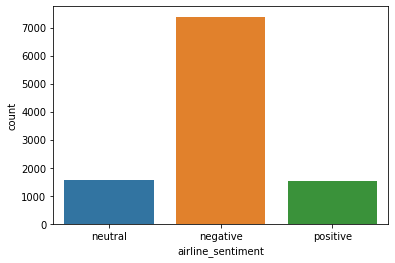

In [110]:
# Histogram of tweet classes

sns.countplot(x='airline_sentiment', data=kaggle_df);

###### Wordcloud for all labeled tweets

In [111]:
# Instantiate a wordcloud object

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_list, 
                min_font_size = 10)

In [112]:
kaggle_text_list = []
for tweet in kaggle_df.clean_text:
    tweet = re.sub("southwestair", "", tweet)
    tweet = re.sub("united", "", tweet)
    tweet = re.sub("americanair", "", tweet)
    tweet = re.sub("usairways", "", tweet)
    tweet = re.sub("jetblue", "", tweet)
    tweet = re.sub("virginamerica", "", tweet)
    tweet = re.sub("amp", "", tweet)
    tweet = re.sub("flight", "", tweet)
    kaggle_text_list.append(tweet)

kaggle_text = ' '.join(kaggle_text_list)

In [113]:
wordcloud.generate(kaggle_text)

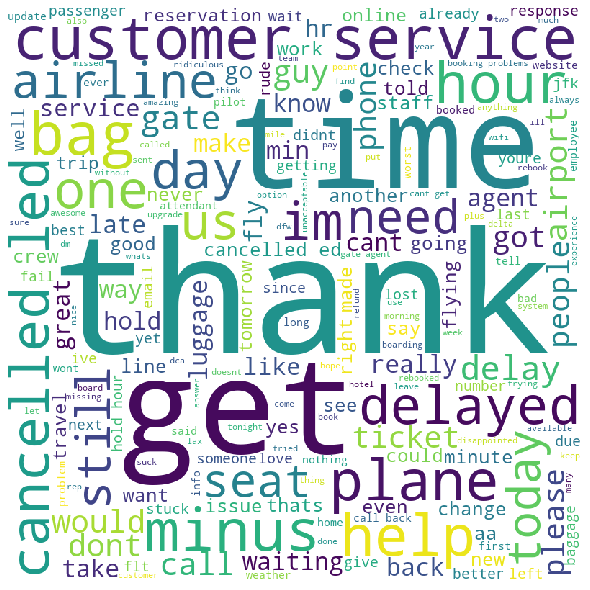

In [114]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

###### Positive Tweets Wordcloud

In [115]:
kaggle_positive = kaggle_df[kaggle_df['airline_sentiment'] == 'positive']

In [116]:
kaggle_positive_list = []
for tweet in kaggle_positive.clean_text:
    tweet = re.sub("southwestair", "", tweet)
    tweet = re.sub("united", "", tweet)
    tweet = re.sub("americanair", "", tweet)
    tweet = re.sub("usairways", "", tweet)
    tweet = re.sub("jetblue", "", tweet)
    tweet = re.sub("virginamerica", "", tweet)
    tweet = re.sub("amp", "", tweet)
    tweet = re.sub("flight", "", tweet)
    kaggle_positive_list.append(tweet)

kaggle_positive_text = ' '.join(kaggle_positive_list)

In [117]:
wordcloud.generate(kaggle_positive_text)

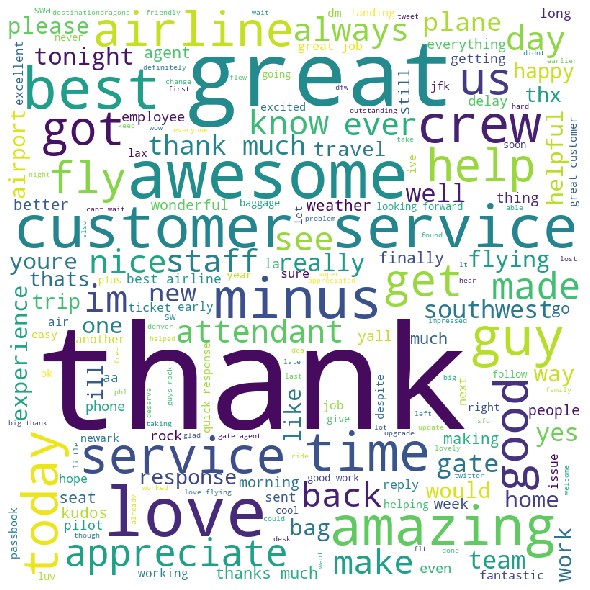

In [118]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

###### Negative Tweets Wordcloud

In [119]:
kaggle_negative = kaggle_df[kaggle_df['airline_sentiment'] == 'negative']

In [120]:
kaggle_negative_list = []
for tweet in kaggle_negative.clean_text:
    tweet = re.sub("southwestair", "", tweet)
    tweet = re.sub("united", "", tweet)
    tweet = re.sub("americanair", "", tweet)
    tweet = re.sub("usairways", "", tweet)
    tweet = re.sub("jetblue", "", tweet)
    tweet = re.sub("virginamerica", "", tweet)
    tweet = re.sub("amp", "", tweet)
    tweet = re.sub("flight", "", tweet)
    kaggle_negative_list.append(tweet)

kaggle_negative_text = ' '.join(kaggle_negative_list)

In [121]:
wordcloud.generate(kaggle_negative_text)

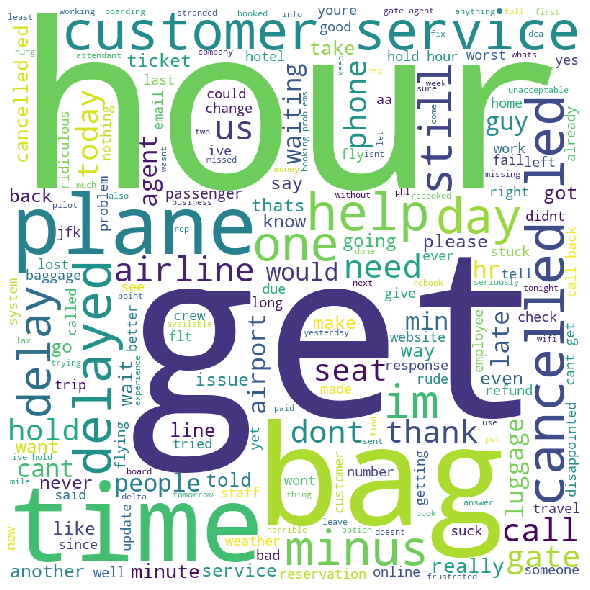

In [122]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

###### Neutral Tweets Wordcloud

In [123]:
kaggle_neutral = kaggle_df[kaggle_df['airline_sentiment'] == 'neutral']

In [124]:
kaggle_neutral_list = []
for tweet in kaggle_neutral.clean_text:
    tweet = re.sub("southwestair", "", tweet)
    tweet = re.sub("united", "", tweet)
    tweet = re.sub("americanair", "", tweet)
    tweet = re.sub("usairways", "", tweet)
    tweet = re.sub("jetblue", "", tweet)
    tweet = re.sub("virginamerica", "", tweet)
    tweet = re.sub("amp", "", tweet)
    tweet = re.sub("flight", "", tweet)
    kaggle_neutral_list.append(tweet)

kaggle_neutral_text = ' '.join(kaggle_neutral_list)

In [125]:
wordcloud.generate(kaggle_neutral_text)

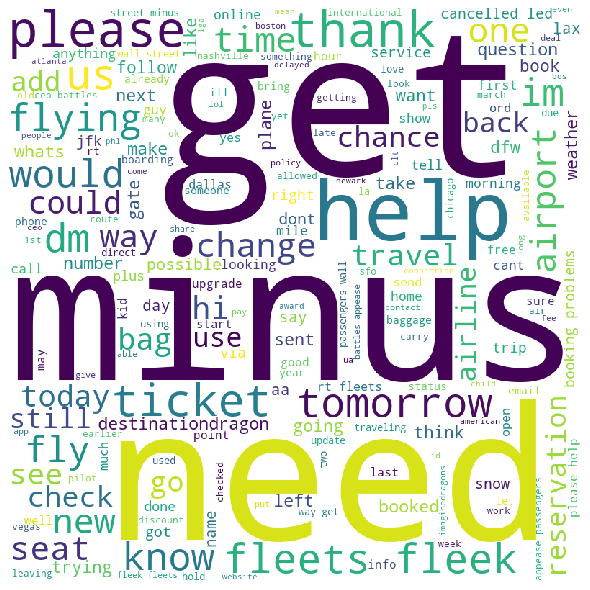

In [126]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [127]:
kaggle_positive

tweet_id airline_sentiment  airline_sentiment_confidence  \
9      570295459631263746          positive                           1.0   
11     570289724453216256          positive                           1.0   
12     570289584061480960          positive                           1.0   
14     570285904809598977          positive                           1.0   
16     570277724385734656          positive                           1.0   
...                   ...               ...                           ...   
14617  569591285150908416          positive                           1.0   
14619  569590988395708416          positive                           1.0   
14625  569589643487928321          positive                           1.0   
14628  569588651925098496          positive                           1.0   
14630  569588473050611712          positive                           1.0   

      negativereason  negativereason_confidence         airline  \
9                NaN                        NaN  Virgin America   
11               NaN                        NaN  Virgin America   
12               NaN                        NaN  Virgin America   
14               NaN                        NaN  Virgin America   
16               NaN                        NaN  Virgin America   
...              ...                        ...             ...   
14617            NaN                        NaN        American   
14619            NaN                        NaN        American   
14625            NaN                        NaN        American   
14628            NaN                        NaN        American   
14630            NaN                        NaN        American   

      airline_sentiment_gold            name negativereason_gold  \
9                        NaN      YupitsTate                 NaN   
11                       NaN    HyperCamiLax                 NaN   
12                       NaN    HyperCamiLax                 NaN   
14                       NaN        sjespers                 NaN   
16                       NaN   ItzBrianHunty                 NaN   
...                      ...             ...                 ...   
14617                    NaN         iambmac                 NaN   
14619                    NaN     howiemandel                 NaN   
14625                    NaN  DrCaseyJRudkin                 NaN   
14628                    NaN        jlhalldc                 NaN   
14630                    NaN  Laurelinesblog                 NaN   

       retweet_count                                               text  \
9                  0  @VirginAmerica it was amazing, and arrived an ...   
11                 0  @VirginAmerica I &lt;3 pretty graphics. so muc...   
12                 0  @VirginAmerica This is such a great deal! Alre...   
14                 0                             @VirginAmerica Thanks!   
16                 0  @VirginAmerica So excited for my first cross c...   
...              ...                                                ...   
14617              0            @AmericanAir DMing you now! Big thanks.   
14619              3  @AmericanAir I love your company and your staf...   
14625              0  @AmericanAir Flight 236 was great. Fantastic c...   
14628              0  Thank you. “@AmericanAir: @jlhalldc Customer R...   
14630              0                        @AmericanAir Thanks! He is.   

                       tweet_coord              tweet_created  \
9                              NaN  2015-02-24 10:53:27 -0800   
11                             NaN  2015-02-24 10:30:40 -0800   
12                             NaN  2015-02-24 10:30:06 -0800   
14                             NaN  2015-02-24 10:15:29 -0800   
16                             NaN  2015-02-24 09:42:59 -0800   
...                            ...                        ...   
14617                          NaN  2015-02-22 12:15:19 -0800   
14619                          NaN  2015-02-22 12

# Model Part 1: Supervised Tf-idf Classifiers

##### To perform supervised learning, the data will be split into two groups:

1) Train - 75% of labeled Kaggle tweets

2) Test - 25% of labeled Kaggle tweets

## LinearSVC Classifier

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [129]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [130]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [131]:
svm_clf = LinearSVC(random_state=1)

In [132]:
svm_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [133]:
svm_test_pred = svm_clf.predict(X_test)

In [134]:
svm_test_acc = round(accuracy_score(y_test, svm_test_pred), 2)

In [135]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_test_acc)

Confusion Matrix:
[[1757   57   20]
 [ 197  169   14]
 [ 154   46  198]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1834
           1       0.62      0.44      0.52       380
           2       0.85      0.50      0.63       398

    accuracy                           0.81      2612
   macro avg       0.77      0.63      0.68      2612
weighted avg       0.81      0.81      0.80      2612

------------------------------------------------------------
Test Accuracy:
0.81


## Random Forest Model Classifier

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [137]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [138]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [139]:
rf_clf = RandomForestClassifier(random_state=1)

In [140]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [141]:
rf_test_pred = rf_clf.predict(X_test)

rf_test_acc = round(accuracy_score(y_test, rf_test_pred), 2)

In [142]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_test_acc)

Confusion Matrix:
[[1756   45   33]
 [ 215  139   26]
 [ 158   38  202]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1834
           1       0.63      0.37      0.46       380
           2       0.77      0.51      0.61       398

    accuracy                           0.80      2612
   macro avg       0.74      0.61      0.65      2612
weighted avg       0.79      0.80      0.78      2612

------------------------------------------------------------
Test Accuracy:
0.8


## Multinomial Naive Bayes Classifier

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [144]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [145]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [146]:
mnb_clf = MultinomialNB()

In [147]:
mnb_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [148]:
mnb_test_pred = mnb_clf.predict(X_test)
mnb_test_acc = round(accuracy_score(y_test, mnb_test_pred), 2)

In [149]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_test_acc)

Confusion Matrix:
[[1828    0    6]
 [ 361   14    5]
 [ 275    2  121]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1834
           1       0.88      0.04      0.07       380
           2       0.92      0.30      0.46       398

    accuracy                           0.75      2612
   macro avg       0.84      0.45      0.46      2612
weighted avg       0.79      0.75      0.68      2612

------------------------------------------------------------
Test Accuracy:
0.75


## AdaBoost Classifier

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [151]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [152]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [153]:
ada_clf = AdaBoostClassifier(random_state=1)

In [154]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [155]:
ada_test_pred = ada_clf.predict(X_test)
ada_test_acc = round(accuracy_score(y_test, ada_test_pred), 2)

In [156]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_test_acc)

Confusion Matrix:
[[1713   84   37]
 [ 184  176   20]
 [ 141   61  196]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1834
           1       0.55      0.46      0.50       380
           2       0.77      0.49      0.60       398

    accuracy                           0.80      2612
   macro avg       0.72      0.63      0.66      2612
weighted avg       0.79      0.80      0.79      2612

------------------------------------------------------------
Test Accuracy:
0.8


## XGBoost Classifier

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [158]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [159]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [160]:
xgb_clf = XGBClassifier(random_state=1)

In [161]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [162]:
xgb_test_pred = xgb_clf.predict(X_test)
xgb_test_acc = round(accuracy_score(y_test, xgb_test_pred), 2)

In [163]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_test_acc)

Confusion Matrix:
[[1786   32   16]
 [ 251  118   11]
 [ 174   40  184]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1834
           1       0.62      0.31      0.41       380
           2       0.87      0.46      0.60       398

    accuracy                           0.80      2612
   macro avg       0.77      0.58      0.63      2612
weighted avg       0.79      0.80      0.77      2612

------------------------------------------------------------
Test Accuracy:
0.8


## Perceptron Classifier

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [165]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [166]:
# X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

In [167]:
# define the keras model
model = Sequential()
model.add(Dense(100, input_dim=100, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [168]:
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [169]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 0s 32us/step - loss: 0.8173 - accuracy: 0.6753 - val_loss: 0.6917 - val_accuracy: 0.7021
Epoch 2/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.6298 - accuracy: 0.7320 - val_loss: 0.5815 - val_accuracy: 0.7634
Epoch 3/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.5402 - accuracy: 0.7890 - val_loss: 0.5135 - val_accuracy: 0.7963
Epoch 4/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.5002 - accuracy: 0.8054 - val_loss: 0.4894 - val_accuracy: 0.8113
Epoch 5/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.4839 - accuracy: 0.8126 - val_loss: 0.4815 - val_accuracy: 0.8128


In [170]:
nn_test_pred = model.predict_classes(X_test)
nn_test_acc = round(accuracy_score(y_test, nn_test_pred), 2)

In [171]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_test_acc)

Confusion Matrix:
[[1744   62   28]
 [ 184  175   21]
 [ 148   46  204]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1834
           1       0.62      0.46      0.53       380
           2       0.81      0.51      0.63       398

    accuracy                           0.81      2612
   macro avg       0.75      0.64      0.68      2612
weighted avg       0.80      0.81      0.80      2612

------------------------------------------------------------
Test Accuracy:
0.81


## Model Part 1 Summary:

In [172]:
models = ['Linear SVC', 'Random Forest', 'Multinomial Naive Bayes', 
                  'AdaBoost', 'XGBoost', 'Perceptron']
tfidf_model_accs = [svm_test_acc, rf_test_acc, mnb_test_acc, ada_test_acc,
                    xgb_test_acc, nn_test_acc]

tfidf_summary = pd.DataFrame([models, tfidf_model_accs]).T

tfidf_summary.columns = ['Classifier', 'Tfidf Accuracy']

In [173]:
tfidf_summary

Classifier Tfidf Accuracy
0               Linear SVC           0.81
1            Random Forest            0.8
2  Multinomial Naive Bayes           0.75
3                 AdaBoost            0.8
4                  XGBoost            0.8
5               Perceptron           0.81

# Model Part 2: Supervised Doc2Vec Classifiers

## Fit Doc2Vec Model on labeled data

In [174]:
kaggle_tokens = list(kaggle_df['tokens'])

In [175]:
tagged_data = [TaggedDocument(words=tweet, tags=[str(i)])for i, tweet in enumerate(kaggle_tokens)]

In [176]:
# Instantiate Doc2Vec (Distributed Memory) model and build model vocabulary from tweet data

model = Doc2Vec(vector_size=100, dm=1, epochs=100)

model.build_vocab(tagged_data)

In [177]:
# Train the model on labeled tweets

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [178]:
# Now, must use trained model to infer vectors for all kaggle labeled tweets

kaggle_vecs = []
for tweet in kaggle_df.tokens:
    vec = model.infer_vector(tweet)
    kaggle_vecs.append(vec)

In [179]:
kaggle_vecs = np.array(kaggle_vecs)

In [180]:
y = kaggle_df.target
X = kaggle_vecs

## LinearSVC Classifier - Supervised d2v

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [182]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [183]:
svm_sd2v = LinearSVC(random_state=1, max_iter=5000)

In [184]:
svm_sd2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [185]:
svm_sd2v_test_pred = svm_sd2v.predict(X_test)

In [186]:
svm_sd2v_test_acc = round(accuracy_score(y_test, svm_sd2v_test_pred), 2)

In [187]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_sd2v_test_acc)

Confusion Matrix:
[[1723   48   63]
 [ 262   94   24]
 [ 187   19  192]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1834
           1       0.58      0.25      0.35       380
           2       0.69      0.48      0.57       398

    accuracy                           0.77      2612
   macro avg       0.69      0.56      0.59      2612
weighted avg       0.75      0.77      0.74      2612

------------------------------------------------------------
Test Accuracy:
0.77


## Random Forest Model Classifier - Supervised d2v

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [189]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [190]:
rf_sd2v_clf = RandomForestClassifier(random_state=1)

In [191]:
rf_sd2v_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [192]:
rf_sd2v_test_pred = rf_sd2v_clf.predict(X_test)

rf_sd2v_test_acc = round(accuracy_score(y_test, rf_sd2v_test_pred), 2)

In [193]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_sd2v_test_acc)

Confusion Matrix:
[[1826    7    1]
 [ 328   47    5]
 [ 298   16   84]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1834
           1       0.67      0.12      0.21       380
           2       0.93      0.21      0.34       398

    accuracy                           0.75      2612
   macro avg       0.78      0.44      0.47      2612
weighted avg       0.76      0.75      0.68      2612

------------------------------------------------------------
Test Accuracy:
0.75


## Multinomial Naive Bayes Classifier - Supervised d2v

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [195]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [196]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [197]:
mnb_sd2v_clf = MultinomialNB()

In [198]:
mnb_sd2v_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [199]:
mnb_sd2v_test_pred = mnb_sd2v_clf.predict(X_test)
mnb_sd2v_test_acc = round(accuracy_score(y_test, mnb_sd2v_test_pred), 2)

In [200]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_sd2v_test_acc)

Confusion Matrix:
[[1834    0    0]
 [ 380    0    0]
 [ 398    0    0]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1834
           1       0.00      0.00      0.00       380
           2       0.00      0.00      0.00       398

    accuracy                           0.70      2612
   macro avg       0.23      0.33      0.28      2612
weighted avg       0.49      0.70      0.58      2612

------------------------------------------------------------
Test Accuracy:
0.7


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## AdaBoost Classifier - Supervised d2v

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [202]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [203]:
ada_sd2v_clf = AdaBoostClassifier(random_state=1)

In [204]:
ada_sd2v_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [205]:
ada_sd2v_test_pred = ada_sd2v_clf.predict(X_test)
ada_sd2v_test_acc = round(accuracy_score(y_test, ada_sd2v_test_pred), 2)

In [206]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_sd2v_test_acc)

Confusion Matrix:
[[1686   80   68]
 [ 233  105   42]
 [ 172   43  183]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1834
           1       0.46      0.28      0.35       380
           2       0.62      0.46      0.53       398

    accuracy                           0.76      2612
   macro avg       0.63      0.55      0.58      2612
weighted avg       0.73      0.76      0.73      2612

------------------------------------------------------------
Test Accuracy:
0.76


## XGBoost Classifier - Supervised d2v

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [208]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [209]:
xgb_sd2v_clf = XGBClassifier(random_state=1)

In [210]:
xgb_sd2v_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [211]:
xgb_sd2v_test_pred = xgb_sd2v_clf.predict(X_test)
xgb_sd2v_test_acc = round(accuracy_score(y_test, xgb_sd2v_test_pred), 2)

In [212]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_sd2v_test_acc)

Confusion Matrix:
[[1789   32   13]
 [ 270   90   20]
 [ 226   25  147]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1834
           1       0.61      0.24      0.34       380
           2       0.82      0.37      0.51       398

    accuracy                           0.78      2612
   macro avg       0.74      0.53      0.57      2612
weighted avg       0.76      0.78      0.74      2612

------------------------------------------------------------
Test Accuracy:
0.78


## Perceptron Classifier - Supervised d2v

In [213]:
y = kaggle_df.target
X = kaggle_vecs

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [215]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [216]:
# define the keras model
percep_sd2v = Sequential()
percep_sd2v.add(Dense(100, input_dim=100, activation='relu'))
percep_sd2v.add(Dense(3, activation='softmax'))

In [217]:
# compile the keras model
percep_sd2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [218]:
# fit the keras model on the dataset
percep_sd2v.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 0s 24us/step - loss: 0.7458 - accuracy: 0.6775 - val_loss: 0.6243 - val_accuracy: 0.7270
Epoch 2/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.5702 - accuracy: 0.7625 - val_loss: 0.5452 - val_accuracy: 0.7898
Epoch 3/5
7833/7833 [==============================] - 0s 13us/step - loss: 0.5102 - accuracy: 0.8011 - val_loss: 0.5115 - val_accuracy: 0.8051
Epoch 4/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.4773 - accuracy: 0.8160 - val_loss: 0.4988 - val_accuracy: 0.8070
Epoch 5/5
7833/7833 [==============================] - 0s 13us/step - loss: 0.4543 - accuracy: 0.8280 - val_loss: 0.4928 - val_accuracy: 0.8097


In [219]:
nn_sd2v_test_pred = percep_sd2v.predict_classes(X_test)
nn_sd2v_test_acc = round(accuracy_score(y_test, nn_sd2v_test_pred), 2)

In [220]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_sd2v_test_acc)

Confusion Matrix:
[[1751   48   35]
 [ 224  135   21]
 [ 132   37  229]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1834
           1       0.61      0.36      0.45       380
           2       0.80      0.58      0.67       398

    accuracy                           0.81      2612
   macro avg       0.75      0.63      0.67      2612
weighted avg       0.80      0.81      0.79      2612

------------------------------------------------------------
Test Accuracy:
0.81


## Model Part 2 Summary:

In [221]:
sd2v_model_accs = [svm_sd2v_test_acc, rf_sd2v_test_acc, mnb_sd2v_test_acc, ada_sd2v_test_acc,
                    xgb_sd2v_test_acc, nn_sd2v_test_acc]

tfidf_summary['Supervised d2v Accuracy'] = sd2v_model_accs

summary_table = tfidf_summary

display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy
0               Linear SVC           0.81                     0.77
1            Random Forest            0.8                     0.75
2  Multinomial Naive Bayes           0.75                     0.70
3                 AdaBoost            0.8                     0.76
4                  XGBoost            0.8                     0.78
5               Perceptron           0.81                     0.81

# Model Part 3: Semi-Supervised Doc2Vec Classifiers

## Fit Doc2Vec Model on labeled & unlabeled data

In [222]:
kaggle_tokens = kaggle_df['tokens']

In [223]:
twitter_tokens = twitter_df['tokens']

In [224]:
# Combine all tokenized tweets, since we want to train Doc2Vec on all available data

all_tokens = list(kaggle_tokens.append(twitter_tokens))

In [225]:
tagged_data = [TaggedDocument(words=tweet, tags=[str(i)])for i, tweet in enumerate(all_tokens)]

In [226]:
# Instantiate Doc2Vec (Distributed Memory) model and build model vocabulary from tweet data

model = Doc2Vec(vector_size=100, dm=1, epochs=100)

model.build_vocab(tagged_data)

In [227]:
# Train the model on full text data (ok to use all unlabled and labeled data)

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [228]:
# Now, must use trained model to infer vectors for all kaggle labeled tweets

kaggle_vecs = []
for tweet in kaggle_df.tokens:
    vec = model.infer_vector(tweet)
    kaggle_vecs.append(vec)

In [229]:
kaggle_vecs = np.array(kaggle_vecs)

In [230]:
y = kaggle_df.target
X = kaggle_vecs

## LinearSVC Classifier - Semi-Supervised d2v

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [232]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [233]:
svm_ssd2v = LinearSVC(random_state=1, max_iter=10000)

In [234]:
svm_ssd2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [235]:
svm_ssd2v_test_pred = svm_ssd2v.predict(X_test)

In [236]:
svm_ssd2v_test_acc = round(accuracy_score(y_test, svm_ssd2v_test_pred), 2)

In [237]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_ssd2v_test_acc)

Confusion Matrix:
[[1730   51   53]
 [ 221  133   26]
 [ 116   33  249]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1834
           1       0.61      0.35      0.45       380
           2       0.76      0.63      0.69       398

    accuracy                           0.81      2612
   macro avg       0.74      0.64      0.67      2612
weighted avg       0.79      0.81      0.79      2612

------------------------------------------------------------
Test Accuracy:
0.81


## Random Forest Model Classifier - Semi-Supervised d2v

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [239]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [240]:
rf_ssd2v_clf = RandomForestClassifier(random_state=1)

In [241]:
rf_ssd2v_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [242]:
rf_ssd2v_test_pred = rf_ssd2v_clf.predict(X_test)

rf_ssd2v_test_acc = round(accuracy_score(y_test, rf_ssd2v_test_pred), 2)

In [243]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_ssd2v_test_acc)

Confusion Matrix:
[[1824    6    4]
 [ 341   34    5]
 [ 308   11   79]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1834
           1       0.67      0.09      0.16       380
           2       0.90      0.20      0.33       398

    accuracy                           0.74      2612
   macro avg       0.77      0.43      0.44      2612
weighted avg       0.75      0.74      0.67      2612

------------------------------------------------------------
Test Accuracy:
0.74


## Multinomial Naive Bayes Classifier - Semi-Supervised d2v

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [245]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [246]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [247]:
mnb_ssd2v_clf = MultinomialNB()

In [248]:
mnb_ssd2v_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [249]:
mnb_ssd2v_test_pred = mnb_ssd2v_clf.predict(X_test)
mnb_ssd2v_test_acc = round(accuracy_score(y_test, mnb_ssd2v_test_pred), 2)

In [250]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_ssd2v_test_acc)

Confusion Matrix:
[[1834    0    0]
 [ 380    0    0]
 [ 398    0    0]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1834
           1       0.00      0.00      0.00       380
           2       0.00      0.00      0.00       398

    accuracy                           0.70      2612
   macro avg       0.23      0.33      0.28      2612
weighted avg       0.49      0.70      0.58      2612

------------------------------------------------------------
Test Accuracy:
0.7


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## AdaBoost Classifier - Semi-Supervised d2v

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [252]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [253]:
ada_ssd2v_clf = AdaBoostClassifier(random_state=1)

In [254]:
ada_ssd2v_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [255]:
ada_ssd2v_test_pred = ada_ssd2v_clf.predict(X_test)
ada_ssd2v_test_acc = round(accuracy_score(y_test, ada_ssd2v_test_pred), 2)

In [256]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_ssd2v_test_acc)

Confusion Matrix:
[[1686   79   69]
 [ 227  105   48]
 [ 160   54  184]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1834
           1       0.44      0.28      0.34       380
           2       0.61      0.46      0.53       398

    accuracy                           0.76      2612
   macro avg       0.62      0.55      0.58      2612
weighted avg       0.73      0.76      0.74      2612

------------------------------------------------------------
Test Accuracy:
0.76


## XGBoost Classifier - Semi-Supervised d2v

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [258]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [259]:
xgb_ssd2v_clf = XGBClassifier(random_state=1)

In [260]:
xgb_ssd2v_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [261]:
xgb_ssd2v_test_pred = xgb_ssd2v_clf.predict(X_test)
xgb_ssd2v_test_acc = round(accuracy_score(y_test, xgb_ssd2v_test_pred), 2)

In [262]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_ssd2v_test_acc)

Confusion Matrix:
[[1794   24   16]
 [ 281   76   23]
 [ 218   19  161]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1834
           1       0.64      0.20      0.30       380
           2       0.81      0.40      0.54       398

    accuracy                           0.78      2612
   macro avg       0.74      0.53      0.57      2612
weighted avg       0.76      0.78      0.74      2612

------------------------------------------------------------
Test Accuracy:
0.78


## Perceptron Classifier - Semi-Supervised d2v

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [264]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [265]:
# define the keras model
percep_ssd2v = Sequential()
percep_ssd2v.add(Dense(100, input_dim=100, activation='relu'))
percep_ssd2v.add(Dense(3, activation='softmax'))

In [266]:
# compile the keras model
percep_ssd2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [267]:
# fit the keras model on the dataset
percep_ssd2v.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 0s 19us/step - loss: 0.7094 - accuracy: 0.7069 - val_loss: 0.5711 - val_accuracy: 0.7707
Epoch 2/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.5215 - accuracy: 0.7864 - val_loss: 0.5010 - val_accuracy: 0.8005
Epoch 3/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.4671 - accuracy: 0.8153 - val_loss: 0.4759 - val_accuracy: 0.8166
Epoch 4/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.4368 - accuracy: 0.8284 - val_loss: 0.4642 - val_accuracy: 0.8239
Epoch 5/5
7833/7833 [==============================] - 0s 13us/step - loss: 0.4145 - accuracy: 0.8412 - val_loss: 0.4597 - val_accuracy: 0.8235


In [268]:
nn_ssd2v_test_pred = percep_ssd2v.predict_classes(X_test)
nn_ssd2v_test_acc = round(accuracy_score(y_test, nn_ssd2v_test_pred), 2)

In [269]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_ssd2v_test_acc)

Confusion Matrix:
[[1740   52   42]
 [ 202  143   35]
 [ 101   29  268]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1834
           1       0.64      0.38      0.47       380
           2       0.78      0.67      0.72       398

    accuracy                           0.82      2612
   macro avg       0.76      0.67      0.70      2612
weighted avg       0.81      0.82      0.81      2612

------------------------------------------------------------
Test Accuracy:
0.82


## Model Part 3 Summary:

In [270]:
ssd2v_model_accs = [svm_ssd2v_test_acc, rf_ssd2v_test_acc, mnb_ssd2v_test_acc, ada_ssd2v_test_acc,
                    xgb_ssd2v_test_acc, nn_ssd2v_test_acc]

summary_table['Semi-Supervised d2v Accuracy'] = ssd2v_model_accs


display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy  \
0               Linear SVC           0.81                     0.77   
1            Random Forest            0.8                     0.75   
2  Multinomial Naive Bayes           0.75                     0.70   
3                 AdaBoost            0.8                     0.76   
4                  XGBoost            0.8                     0.78   
5               Perceptron           0.81                     0.81   

   Semi-Supervised d2v Accuracy  
0                          0.81  
1                          0.74  
2                          0.70  
3                          0.76  
4                          0.78  
5                          0.82

Feeding ~5x more data to the Doc2Vec model helps the accuracy of each classifier, but none exceed accuracy of the initial tf-idf classifiers. This is probably becuase the Doc2Vec model still hasn't had enough data to train on.

# Model Part 4: GloVe Word Embedding Classifiers - 100d

## Get GloVe Embeddings for Labeled Tweets

In [271]:
# Labeled tweets vocabulary

total_vocabulary = set(word for tweet in kaggle_df.tokens for word in tweet)

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 12301 unique tokens in the dataset.


In [272]:
# See available files for GloVe

os.listdir("C:/Users/dougl/glove.twitter.27B/")

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt']

In [273]:
# Get GloVe embeddings for each word present in the vocabulary

glove = {}
with open(r'C:/Users/dougl/glove.twitter.27B/glove.twitter.27B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [274]:
# Check length of glove dictionary (number of words in GloVe matched by word in corpus)

print(f'{len(glove)} of {len(total_vocabulary)} tokens in dataset matched in GloVe and vectorized!')

8268 of 12301 tokens in dataset matched in GloVe and vectorized!


## W2vVectorizer class to get GloVe mean word embeddings for tweets

In [275]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        # X should be a series of lists of tokens
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [276]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer = W2vVectorizer(glove)

In [277]:
# Use vectorizer to transform tokenized data to vectors
X_glove = vectorizer.transform(kaggle_df.tokens)

In [278]:
# Check to see if X_glove is correct shape
# Should be # of observations (10445) by # word emb. dimension (100)

X_glove.shape

(10445, 100)

In [279]:
# Get corresponding y

y = kaggle_df.target

y.shape

(10445,)

## LinearSVC Classifier - GloVe Mean Word Embeddings

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [281]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [282]:
svm_glove = LinearSVC(random_state=1, max_iter=10000)

In [283]:
svm_glove.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [284]:
svm_glove_test_pred = svm_glove.predict(X_test)

In [285]:
svm_glove_test_acc = round(accuracy_score(y_test, svm_glove_test_pred), 2)

In [286]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_glove_test_acc)

Confusion Matrix:
[[1785   23   26]
 [ 182  174   24]
 [  66   28  304]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1834
           1       0.77      0.46      0.58       380
           2       0.86      0.76      0.81       398

    accuracy                           0.87      2612
   macro avg       0.84      0.73      0.77      2612
weighted avg       0.86      0.87      0.86      2612

------------------------------------------------------------
Test Accuracy:
0.87


## Random Forest Classifier - GloVe Mean Word Embeddings

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [288]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [289]:
rf_glove = RandomForestClassifier(random_state=1)

In [290]:
rf_glove.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [291]:
rf_glove_test_pred = rf_glove.predict(X_test)

In [292]:
rf_glove_test_acc = round(accuracy_score(y_test, rf_glove_test_pred), 2)

In [293]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_glove_test_acc)

Confusion Matrix:
[[1800   21   13]
 [ 229  133   18]
 [ 147   13  238]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1834
           1       0.80      0.35      0.49       380
           2       0.88      0.60      0.71       398

    accuracy                           0.83      2612
   macro avg       0.84      0.64      0.70      2612
weighted avg       0.83      0.83      0.81      2612

------------------------------------------------------------
Test Accuracy:
0.83


## Multinomial Naive Bayes Classifier - GloVe Mean Word Embeddings

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [295]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [296]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [297]:
mnb_glove_clf = MultinomialNB()

In [298]:
mnb_glove_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [299]:
mnb_glove_test_pred = mnb_glove_clf.predict(X_test)
mnb_glove_test_acc = round(accuracy_score(y_test, mnb_glove_test_pred), 2)

In [300]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_glove_test_acc)

Confusion Matrix:
[[1834    0    0]
 [ 380    0    0]
 [ 398    0    0]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1834
           1       0.00      0.00      0.00       380
           2       0.00      0.00      0.00       398

    accuracy                           0.70      2612
   macro avg       0.23      0.33      0.28      2612
weighted avg       0.49      0.70      0.58      2612

------------------------------------------------------------
Test Accuracy:
0.7


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## AdaBoost Classifier - GloVe Mean Word Embeddings

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [302]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [303]:
ada_glove_clf = AdaBoostClassifier(random_state=1)

In [304]:
ada_glove_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [305]:
ada_glove_test_pred = ada_glove_clf.predict(X_test)
ada_glove_test_acc = round(accuracy_score(y_test, ada_glove_test_pred), 2)

In [306]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_glove_test_acc)

Confusion Matrix:
[[1695   84   55]
 [ 175  183   22]
 [  80   33  285]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1834
           1       0.61      0.48      0.54       380
           2       0.79      0.72      0.75       398

    accuracy                           0.83      2612
   macro avg       0.76      0.71      0.73      2612
weighted avg       0.82      0.83      0.82      2612

------------------------------------------------------------
Test Accuracy:
0.83


## XGBoost Classifier - GloVe Mean Word Embeddings

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [308]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [309]:
xgb_glove_clf = XGBClassifier(random_state=1)

In [310]:
xgb_glove_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [311]:
xgb_glove_test_pred = xgb_glove_clf.predict(X_test)
xgb_glove_test_acc = round(accuracy_score(y_test, xgb_glove_test_pred), 2)

In [312]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_glove_test_acc)

Confusion Matrix:
[[1784   33   17]
 [ 181  179   20]
 [ 101   22  275]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1834
           1       0.76      0.47      0.58       380
           2       0.88      0.69      0.77       398

    accuracy                           0.86      2612
   macro avg       0.84      0.71      0.76      2612
weighted avg       0.85      0.86      0.85      2612

------------------------------------------------------------
Test Accuracy:
0.86


## Perceptron Classifier - GloVe Word Embeddings

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, y, test_size=0.25, random_state=1)

In [314]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [315]:
# define the keras model
percep_glove = Sequential()
percep_glove.add(Dense(100, input_dim=100, activation='relu'))
percep_glove.add(Dense(3, activation='softmax'))

In [316]:
# compile the keras model
percep_glove.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [317]:
# fit the keras model on the dataset
percep_glove.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 0s 19us/step - loss: 0.6583 - accuracy: 0.7434 - val_loss: 0.5171 - val_accuracy: 0.8025
Epoch 2/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.4795 - accuracy: 0.8245 - val_loss: 0.4188 - val_accuracy: 0.8568
Epoch 3/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.4243 - accuracy: 0.8420 - val_loss: 0.3862 - val_accuracy: 0.8683
Epoch 4/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.3970 - accuracy: 0.8564 - val_loss: 0.3721 - val_accuracy: 0.8694
Epoch 5/5
7833/7833 [==============================] - 0s 12us/step - loss: 0.3806 - accuracy: 0.8606 - val_loss: 0.3627 - val_accuracy: 0.8725


In [318]:
nn_glove_test_pred = percep_glove.predict_classes(X_test)
nn_glove_test_acc = round(accuracy_score(y_test, nn_glove_test_pred), 2)

In [319]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_glove_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_glove_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_glove_test_acc)

Confusion Matrix:
[[1775   33   26]
 [ 153  205   22]
 [  68   31  299]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1834
           1       0.76      0.54      0.63       380
           2       0.86      0.75      0.80       398

    accuracy                           0.87      2612
   macro avg       0.84      0.75      0.79      2612
weighted avg       0.87      0.87      0.87      2612

------------------------------------------------------------
Test Accuracy:
0.87


## Model Part 4 Summary

In [320]:
glove_model_accs = [svm_glove_test_acc, rf_glove_test_acc, mnb_glove_test_acc, ada_glove_test_acc,
                    xgb_glove_test_acc, nn_glove_test_acc]

summary_table['GloVe Accuracy - 100d'] = glove_model_accs


display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy  \
0               Linear SVC           0.81                     0.77   
1            Random Forest            0.8                     0.75   
2  Multinomial Naive Bayes           0.75                     0.70   
3                 AdaBoost            0.8                     0.76   
4                  XGBoost            0.8                     0.78   
5               Perceptron           0.81                     0.81   

   Semi-Supervised d2v Accuracy  GloVe Accuracy - 100d  
0                          0.81                   0.87  
1                          0.74                   0.83  
2                          0.70                   0.70  
3                          0.76                   0.83  
4                          0.78                   0.86  
5                          0.82                   0.87

# Model Part 5: GloVe Embedding Classifiers - 200d

## Get GloVe Embeddings for Labeled Tweets

In [321]:
# Labeled tweets vocabulary

total_vocabulary = set(word for tweet in kaggle_df.tokens for word in tweet)

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 12301 unique tokens in the dataset.


In [322]:
# See available files for GloVe

os.listdir("C:/Users/dougl/glove.twitter.27B/")

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt']

In [323]:
# Get GloVe embeddings for each word present in the vocabulary

glove_200 = {}
with open(r'C:/Users/dougl/glove.twitter.27B/glove.twitter.27B.200d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_200[word] = vector

In [324]:
# Check length of glove dictionary (number of words in GloVe matched by word in corpus)

print(f'{len(glove_200)} of {len(total_vocabulary)} tokens in dataset matched in GloVe and vectorized!')

8268 of 12301 tokens in dataset matched in GloVe and vectorized!


## Get GloVe mean word embeddings for tweets

In [325]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer_200 = W2vVectorizer(glove_200)

In [326]:
# Use vectorizer to transform tokenized data to vectors
X_glove_200 = vectorizer_200.transform(kaggle_df.tokens)

In [327]:
# Check to see if X_glove is correct shape
# Should be # of observations (10445) by # word emb. dimension (100)

X_glove_200.shape

(10445, 200)

In [328]:
# Get corresponding y

y = kaggle_df.target

y.shape

(10445,)

## LinearSVC Classifier - GloVe 200d

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [330]:
svm_glove_200 = LinearSVC(random_state=1, max_iter=10000)

In [331]:
svm_glove_200.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [332]:
svm_glove_200_test_pred = svm_glove_200.predict(X_test)

In [333]:
svm_glove_200_test_acc = round(accuracy_score(y_test, svm_glove_200_test_pred), 2)

In [334]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_glove_200_test_acc)

Confusion Matrix:
[[1768   35   31]
 [ 134  222   24]
 [  54   28  316]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1834
           1       0.78      0.58      0.67       380
           2       0.85      0.79      0.82       398

    accuracy                           0.88      2612
   macro avg       0.84      0.78      0.81      2612
weighted avg       0.88      0.88      0.88      2612

------------------------------------------------------------
Test Accuracy:
0.88


## Random Forest Classifier - GloVe 200d

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [336]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [337]:
rf_glove_200 = RandomForestClassifier(random_state=1)

In [338]:
rf_glove_200.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [339]:
rf_glove_200_test_pred = rf_glove_200.predict(X_test)

In [340]:
rf_glove_200_test_acc = round(accuracy_score(y_test, rf_glove_200_test_pred), 2)

In [341]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_glove_200_test_acc)

Confusion Matrix:
[[1811   13   10]
 [ 234  126   20]
 [ 158   14  226]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1834
           1       0.82      0.33      0.47       380
           2       0.88      0.57      0.69       398

    accuracy                           0.83      2612
   macro avg       0.84      0.63      0.69      2612
weighted avg       0.83      0.83      0.80      2612

------------------------------------------------------------
Test Accuracy:
0.83


## Multinomial Naive Bayes Classifier - GloVe 200d

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [343]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [344]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [345]:
mnb_glove_200 = MultinomialNB()

In [346]:
mnb_glove_200.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [347]:
mnb_glove_200_test_pred = mnb_glove_200.predict(X_test)
mnb_glove_200_test_acc = round(accuracy_score(y_test, mnb_glove_200_test_pred), 2)

In [348]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_glove_200_test_acc)

Confusion Matrix:
[[1834    0    0]
 [ 380    0    0]
 [ 385    0   13]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1834
           1       0.00      0.00      0.00       380
           2       1.00      0.03      0.06       398

    accuracy                           0.71      2612
   macro avg       0.57      0.34      0.30      2612
weighted avg       0.65      0.71      0.59      2612

------------------------------------------------------------
Test Accuracy:
0.71


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## AdaBoost Classifier - GloVe 200d

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [350]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [351]:
ada_glove_200 = AdaBoostClassifier(random_state=1)

In [352]:
ada_glove_200.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [353]:
ada_glove_200_test_pred = ada_glove_200.predict(X_test)
ada_glove_200_test_acc = round(accuracy_score(y_test, ada_glove_200_test_pred), 2)

In [354]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_glove_200_test_acc)

Confusion Matrix:
[[1721   70   43]
 [ 183  164   33]
 [  96   35  267]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1834
           1       0.61      0.43      0.51       380
           2       0.78      0.67      0.72       398

    accuracy                           0.82      2612
   macro avg       0.75      0.68      0.71      2612
weighted avg       0.81      0.82      0.81      2612

------------------------------------------------------------
Test Accuracy:
0.82


## XGBoost Classifier - GloVe 200d

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [356]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [357]:
xgb_glove_200 = XGBClassifier(random_state=1)

In [358]:
xgb_glove_200.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [359]:
xgb_glove_200_test_pred = xgb_glove_200.predict(X_test)
xgb_glove_200_test_acc = round(accuracy_score(y_test, xgb_glove_200_test_pred), 2)

In [360]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_glove_200_test_acc)

Confusion Matrix:
[[1787   26   21]
 [ 178  178   24]
 [  99   17  282]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1834
           1       0.81      0.47      0.59       380
           2       0.86      0.71      0.78       398

    accuracy                           0.86      2612
   macro avg       0.84      0.72      0.76      2612
weighted avg       0.86      0.86      0.85      2612

------------------------------------------------------------
Test Accuracy:
0.86


## Perceptron Classifier - GloVe 200d

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X_glove_200, y, test_size=0.25, random_state=1)

In [362]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [363]:
# define the keras model
percep_glove_200 = Sequential()
percep_glove_200.add(Dense(100, input_dim=200, activation='relu'))
percep_glove_200.add(Dense(3, activation='softmax'))

In [364]:
# compile the keras model
percep_glove_200.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [365]:
# fit the keras model on the dataset
percep_glove_200.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 0s 25us/step - loss: 0.6379 - accuracy: 0.7553 - val_loss: 0.4861 - val_accuracy: 0.8155
Epoch 2/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.4486 - accuracy: 0.8343 - val_loss: 0.3888 - val_accuracy: 0.8668
Epoch 3/5
7833/7833 [==============================] - 0s 14us/step - loss: 0.3876 - accuracy: 0.8591 - val_loss: 0.3595 - val_accuracy: 0.8733
Epoch 4/5
7833/7833 [==============================] - 0s 14us/step - loss: 0.3588 - accuracy: 0.8705 - val_loss: 0.3433 - val_accuracy: 0.8867
Epoch 5/5
7833/7833 [==============================] - 0s 15us/step - loss: 0.3410 - accuracy: 0.8781 - val_loss: 0.3360 - val_accuracy: 0.8890


In [366]:
nn_glove_200_test_pred = percep_glove_200.predict_classes(X_test)
nn_glove_200_test_acc = round(accuracy_score(y_test, nn_glove_200_test_pred), 2)

In [367]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_glove_200_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_glove_200_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_glove_200_test_acc)

Confusion Matrix:
[[1756   54   24]
 [ 110  252   18]
 [  47   37  314]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1834
           1       0.73      0.66      0.70       380
           2       0.88      0.79      0.83       398

    accuracy                           0.89      2612
   macro avg       0.84      0.80      0.82      2612
weighted avg       0.89      0.89      0.89      2612

------------------------------------------------------------
Test Accuracy:
0.89


## Model Part 5 Summary

In [368]:
glove_200_model_accs = [svm_glove_200_test_acc, rf_glove_200_test_acc, mnb_glove_200_test_acc, 
                        ada_glove_200_test_acc, xgb_glove_200_test_acc, nn_glove_200_test_acc]

summary_table['GloVe Accuracy - 200d'] = glove_200_model_accs


display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy  \
0               Linear SVC           0.81                     0.77   
1            Random Forest            0.8                     0.75   
2  Multinomial Naive Bayes           0.75                     0.70   
3                 AdaBoost            0.8                     0.76   
4                  XGBoost            0.8                     0.78   
5               Perceptron           0.81                     0.81   

   Semi-Supervised d2v Accuracy  GloVe Accuracy - 100d  GloVe Accuracy - 200d  
0                          0.81                   0.87                   0.88  
1                          0.74                   0.83                   0.83  
2                          0.70                   0.70                   0.71  
3                          0.76                   0.83                   0.82  
4                          0.78                   0.86                   0.86  
5                          0.82                   0.87                   0.89

# Model Part 6: GloVe + d2v Classifiers


## Get GloVe Embeddings

In [369]:
# Labeled tweets vocabulary (full - labeled and unlabeled)
tokens = kaggle_df['tokens'].append(twitter_df['tokens'])
full_vocabulary = set(word for tweet in tokens for word in tweet)

len(full_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(full_vocabulary)))

There are 53485 unique tokens in the dataset.


In [370]:
# See available files for GloVe

os.listdir("C:/Users/dougl/glove.twitter.27B/")

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt']

In [371]:
# Get GloVe embeddings for each word present in the vocabulary

glove_full = {}
with open(r'C:/Users/dougl/glove.twitter.27B/glove.twitter.27B.200d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in full_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove_full[word] = vector

In [372]:
# Check length of glove dictionary (number of words in GloVe matched by word in corpus)

print(f'{len(glove_full)} of {len(full_vocabulary)} tokens in dataset matched in GloVe and vectorized!')

24597 of 53485 tokens in dataset matched in GloVe and vectorized!


## Get GloVe mean word embeddings

In [373]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer_full = W2vVectorizer(glove_full)

In [374]:
# Use vectorizer to transform tokenized data to vectors

X_glove = vectorizer_full.transform(kaggle_df.tokens)

In [375]:
X_d2v = kaggle_vecs

In [376]:
# Combine GloVe and d2v embeddings for final X dataset
X_g_d2v = np.concatenate((X_glove, X_d2v), axis=1)

## LinearSVC Classifier - GloVe + d2v

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [378]:
svm_gd2v = LinearSVC(random_state=1, max_iter=10000)

In [379]:
svm_gd2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [380]:
svm_gd2v_test_pred = svm_gd2v.predict(X_test)

In [381]:
svm_gd2v_test_acc = round(accuracy_score(y_test, svm_gd2v_test_pred), 2)

In [382]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_gd2v_test_acc)

Confusion Matrix:
[[1770   37   27]
 [ 122  235   23]
 [  46   25  327]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1834
           1       0.79      0.62      0.69       380
           2       0.87      0.82      0.84       398

    accuracy                           0.89      2612
   macro avg       0.86      0.80      0.83      2612
weighted avg       0.89      0.89      0.89      2612

------------------------------------------------------------
Test Accuracy:
0.89


## Random Forest Classifier - GloVe + d2v

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [384]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [385]:
rf_gd2v = RandomForestClassifier(random_state=1)

In [386]:
rf_gd2v.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [387]:
rf_gd2v_test_pred = rf_gd2v.predict(X_test)

In [388]:
rf_gd2v_test_acc = round(accuracy_score(y_test, rf_gd2v_test_pred), 2)

In [389]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_gd2v_test_acc)

Confusion Matrix:
[[1815   15    4]
 [ 249  111   20]
 [ 177   10  211]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1834
           1       0.82      0.29      0.43       380
           2       0.90      0.53      0.67       398

    accuracy                           0.82      2612
   macro avg       0.84      0.60      0.66      2612
weighted avg       0.82      0.82      0.79      2612

------------------------------------------------------------
Test Accuracy:
0.82


## Multinomial Naive Bayes Classifier - GloVe + d2v

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [391]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [392]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [393]:
mnb_gd2v = MultinomialNB()

In [394]:
mnb_gd2v.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [395]:
mnb_gd2v_test_pred = mnb_gd2v.predict(X_test)
mnb_gd2v_test_acc = round(accuracy_score(y_test, mnb_gd2v_test_pred), 2)

In [396]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_gd2v_test_acc)

Confusion Matrix:
[[1834    0    0]
 [ 380    0    0]
 [ 385    0   13]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1834
           1       0.00      0.00      0.00       380
           2       1.00      0.03      0.06       398

    accuracy                           0.71      2612
   macro avg       0.57      0.34      0.30      2612
weighted avg       0.65      0.71      0.59      2612

------------------------------------------------------------
Test Accuracy:
0.71


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## AdaBoost Classifier - GloVe + d2v

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [398]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [399]:
ada_gd2v = AdaBoostClassifier(random_state=1)

In [400]:
ada_gd2v.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [401]:
ada_gd2v_test_pred = ada_gd2v.predict(X_test)
ada_gd2v_test_acc = round(accuracy_score(y_test, ada_gd2v_test_pred), 2)

In [402]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_gd2v_test_acc)

Confusion Matrix:
[[1713   86   35]
 [ 177  168   35]
 [  92   33  273]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1834
           1       0.59      0.44      0.50       380
           2       0.80      0.69      0.74       398

    accuracy                           0.82      2612
   macro avg       0.75      0.69      0.71      2612
weighted avg       0.81      0.82      0.82      2612

------------------------------------------------------------
Test Accuracy:
0.82


## XGBoost Classifier - GloVe + d2v

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [404]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [405]:
xgb_gd2v = XGBClassifier(random_state=1)

In [406]:
xgb_gd2v.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [407]:
xgb_gd2v_test_pred = xgb_gd2v.predict(X_test)
xgb_gd2v_test_acc = round(accuracy_score(y_test, xgb_gd2v_test_pred), 2)

In [408]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_gd2v_test_acc)

Confusion Matrix:
[[1793   26   15]
 [ 182  174   24]
 [  99   16  283]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1834
           1       0.81      0.46      0.58       380
           2       0.88      0.71      0.79       398

    accuracy                           0.86      2612
   macro avg       0.85      0.72      0.76      2612
weighted avg       0.86      0.86      0.85      2612

------------------------------------------------------------
Test Accuracy:
0.86


## Perceptron Classifier - GloVe + d2v

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X_g_d2v, y, test_size=0.25, random_state=1)

In [410]:
# X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

In [411]:
# define the keras model
percep_gd2v = Sequential()
percep_gd2v.add(Dense(1000, input_dim=300, activation='relu'))
percep_gd2v.add(Dropout(0.1))
percep_gd2v.add(Dense(100, activation='relu'))
percep_gd2v.add(Dropout(0.1))
percep_gd2v.add(Dense(10, activation='relu'))
percep_gd2v.add(Dense(3, activation='softmax'))

In [412]:
# compile the keras model
percep_gd2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [413]:
# fit the keras model on the dataset
percep_gd2v.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 7833 samples, validate on 2612 samples
Epoch 1/5
7833/7833 [==============================] - 1s 89us/step - loss: 0.5401 - accuracy: 0.7813 - val_loss: 0.4059 - val_accuracy: 0.8476
Epoch 2/5
7833/7833 [==============================] - 1s 69us/step - loss: 0.3688 - accuracy: 0.8649 - val_loss: 0.3582 - val_accuracy: 0.8763
Epoch 3/5
7833/7833 [==============================] - 1s 69us/step - loss: 0.2823 - accuracy: 0.8988 - val_loss: 0.3446 - val_accuracy: 0.8767
Epoch 4/5
7833/7833 [==============================] - 1s 69us/step - loss: 0.2039 - accuracy: 0.9276 - val_loss: 0.3624 - val_accuracy: 0.8683
Epoch 5/5
7833/7833 [==============================] - 1s 69us/step - loss: 0.1436 - accuracy: 0.9525 - val_loss: 0.3776 - val_accuracy: 0.8806


In [414]:
nn_gd2v_test_pred = percep_gd2v.predict_classes(X_test)
nn_gd2v_test_acc = round(accuracy_score(y_test, nn_gd2v_test_pred), 2)

In [415]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_gd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_gd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_gd2v_test_acc)

Confusion Matrix:
[[1718   87   29]
 [  93  271   16]
 [  41   46  311]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1834
           1       0.67      0.71      0.69       380
           2       0.87      0.78      0.82       398

    accuracy                           0.88      2612
   macro avg       0.82      0.81      0.82      2612
weighted avg       0.88      0.88      0.88      2612

------------------------------------------------------------
Test Accuracy:
0.88


## Model Part 6 Summary

In [416]:
gd2v_model_accs = [svm_gd2v_test_acc, rf_gd2v_test_acc, mnb_gd2v_test_acc, 
                        ada_gd2v_test_acc, xgb_gd2v_test_acc, nn_gd2v_test_acc]

summary_table['GloVe + d2v Accuracy'] = gd2v_model_accs


display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy  \
0               Linear SVC           0.81                     0.77   
1            Random Forest            0.8                     0.75   
2  Multinomial Naive Bayes           0.75                     0.70   
3                 AdaBoost            0.8                     0.76   
4                  XGBoost            0.8                     0.78   
5               Perceptron           0.81                     0.81   

   Semi-Supervised d2v Accuracy  GloVe Accuracy - 100d  GloVe Accuracy - 200d  \
0                          0.81                   0.87                   0.88   
1                          0.74                   0.83                   0.83   
2                          0.70                   0.70                   0.71   
3                          0.76                   0.83                   0.82   
4                          0.78                   0.86                   0.86   
5                          0.82                   0.87                   0.89   

   GloVe + d2v Accuracy  
0                  0.89  
1                  0.82  
2                  0.71  
3                  0.82  
4                  0.86  
5                  0.88

# Appendix

##### Plot summary barplot of classifier accuracy

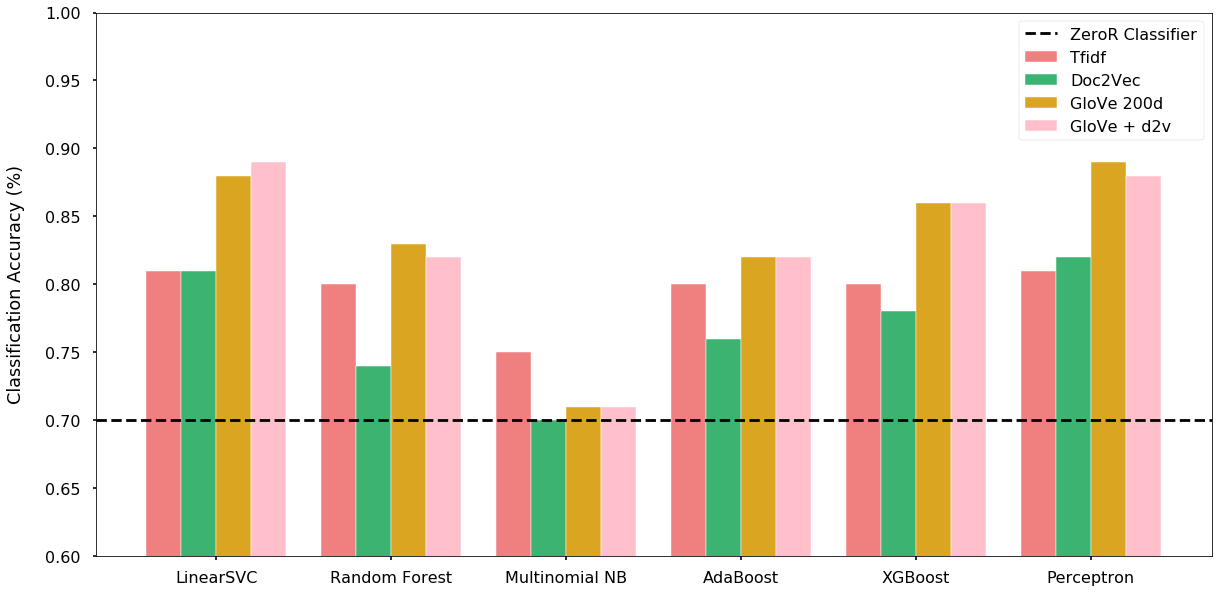

In [453]:

barWidth = 0.2
 
# set height of bar
bars1 = summary_table['Tfidf Accuracy']
# bars2 = summary_table['Supervised d2v Accuracy']
bars3 = summary_table['Semi-Supervised d2v Accuracy']
# bars4 = summary_table['GloVe Accuracy - 100d']
bars5 = summary_table['GloVe Accuracy - 200d']
bars6 = summary_table['GloVe + d2v Accuracy']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
# r5 = [x + barWidth for x in r4]
# r6 = [x + barWidth for x in r5]

plt.figure(figsize=(20,10))
# Make the plot
plt.style.use('seaborn-poster')
plt.bar(r1, bars1, color='lightcoral', width=barWidth, edgecolor='white', label='Tfidf')
# plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='Doc2Vec v1')
plt.bar(r2, bars3, color='mediumseagreen', width=barWidth, edgecolor='white', label='Doc2Vec')
# plt.bar(r4, bars4, color='blue', width=barWidth, edgecolor='white', label='GloVe 100d')
plt.bar(r3, bars5, color='goldenrod', width=barWidth, edgecolor='white', label='GloVe 200d')
plt.bar(r4, bars6, color='pink', width=barWidth, edgecolor='white', label='GloVe + d2v')
 
plt.axhline(y=0.7, label='ZeroR Classifier', linestyle='--', color='black')
# Add xticks on the middle of the group bars
plt.ylabel('Classification Accuracy (%)', labelpad=20)
plt.xticks([r + 1.5*barWidth for r in range(len(bars1))], ['LinearSVC', 'Random Forest', 'Multinomial NB',
                                                       'AdaBoost', 'XGBoost', 'Perceptron'])
plt.ylim((0.6,1))
# Create legend & Show graphic
plt.legend()
plt.show()


##### Take a closer look at which tweets are being classified incorrectly

In [454]:
svm_gd2v_pred_all = svm_gd2v.predict(X_g_d2v)

In [456]:
len(svm_gd2v_pred_all)

10445

In [457]:
kaggle_df['pred_label'] = svm_gd2v_pred_all

In [460]:
misclass_tweets = kaggle_df[kaggle_df['target'] != kaggle_df['pred_label']]

In [473]:
neg_as_pos_df = misclass_tweets[(misclass_tweets['target'] == 0) & (misclass_tweets['pred_label'] == 2)]

In [474]:
for text in neg_as_pos_df.text:
    print(text)

@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
@VirginAmerica called your service line and was hung up on. This is awesome. #sarcasm
@VirginAmerica I did it but there was a problem in the link from the email for check-in. thanks
@VirginAmerica husband and I ordered three drinks via my screen and they never came. Awesome!
@VirginAmerica on flight VX399 headed to LA from JFK - dirtiest VA plane I have ever been on. Sad for a great airline.
@united Lovely new plane from LGA to ORD but no power outlets?
@united Not a happy flyer.  UA flight 1161 from SFO to Cleveland.  Sunday 2/22.  Stay tuned for blog article from http://t.co/VdFdODqVGx
@united hilarious
@united been good 15yr "friendly skies" relationship. 2day agent told me I'm "only Canadian" and thus not good enough for military preboard
@united Good luck with the no-enertainment-on-6-hour-flights strategy. Innovation at work. Hello @jetblue http://t.co/HI7

In [465]:
len(misclass_tweets)

1052